<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: Declare which version of the data we are going to use for exploration

In [1]:
VERSION = '09'

<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: load all dependencies



In [2]:
import pandas as pd
from termcolor import colored
import json

from datetime import datetime
import matplotlib.pyplot as plt

with open('../../z_envs/_envs.json') as f:
    env_vars = json.loads(f.read())
print(env_vars)

try:
    import google.colab

    run_env = 'colab'
except:
    try:
        run_env = env_vars['notebook_environment']
    except:
        run_env = 'unknown'

if run_env not in ['colab', 'gradient', 'cloud']:
    cloud_run = False
    from functions_b__get_the_data_20221116 import set_csv_directory
    set_csv_directory('final_split')
else:
    cloud_run = True
    import sys
    import os

    module_path = os.path.abspath(os.path.join('..', '..', '..'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

from functions_0__common_20221116 import get_columns
from functions_d1__prepare_cleanse_data_20221116 import tidy_dataset
from functions_d2__transform_enrich_data_20221116 import preprocess, feature_engineer
try:
    from functions_d3__prepare_store_data_20221116 import convert_to_dummied
except:
    def convert_to_dummied(df, categories):
        for column in categories:
            df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
            df.drop([column], axis=1, inplace=True)  # now drop the original column (you don't need it anymore),
        return df


{'notebook_environment': 'gradient', 'use_gpu': True, 'debug_mode': False, 'quick_mode': False, 'quick_override_cv_splits': 2, 'quick_override_n_iter': 10, 'quick_override_n_jobs': 3}


<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: get the data

In [3]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [4]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if cloud_run:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        print('loaded data from', folder_prefix + remote_pathname)
        retrieval_type='tidy'
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type

In [5]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/df_listings_v09.csv
(46871, 19)


<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: view the data

In [6]:
df.head(30)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType,feature__balcony,feature__chain free,feature__no onward chain,feature__off street parking,feature__one bedroom,feature__private balcony,feature__share of freehold,feature__three bedrooms,feature__two bedrooms,feature__two double bedrooms
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD,0,0,0,0,0,1,0,0,0,0
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD,1,0,0,0,0,0,0,0,0,1
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD,0,0,1,0,0,0,0,0,0,0
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD,1,0,0,0,0,0,0,0,0,0
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN,0,0,0,0,0,0,0,0,0,0
44749111,475000.0,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD,0,0,0,0,0,0,0,0,0,0
46204665,435000.0,3.0,2.0,0.314779,51.539070,-0.198935,0.039350,0.094515,LEASEHOLD,0,0,0,0,0,0,0,1,0,0
49020666,200000.0,1.0,1.0,0.875911,51.539959,-0.380863,0.040239,0.276443,LEASEHOLD,0,0,0,0,1,0,0,0,0,0
49036279,275000.0,2.0,1.0,0.474368,51.541780,0.037890,0.042060,0.142310,LEASEHOLD,0,0,0,0,0,0,0,0,0,0
49303873,450000.0,3.0,2.0,0.577040,51.524880,0.187200,0.025160,0.291620,FREEHOLD,0,0,0,0,0,0,0,0,0,0


In [7]:
df.isnull().sum()

Price                              0
bedrooms                           0
bathrooms                          0
nearestStation                     0
location.latitude                  0
location.longitude                 0
latitude_deviation                 0
longitude_deviation                0
tenure.tenureType               2744
feature__balcony                   0
feature__chain free                0
feature__no onward chain           0
feature__off street parking        0
feature__one bedroom               0
feature__private balcony           0
feature__share of freehold         0
feature__three bedrooms            0
feature__two bedrooms              0
feature__two double bedrooms       0
dtype: int64

In [8]:
df.info()
df.describe()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46871 entries, 14520525 to 126181118
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Price                         46871 non-null  float64
 1   bedrooms                      46871 non-null  float64
 2   bathrooms                     46871 non-null  float64
 3   nearestStation                46871 non-null  float64
 4   location.latitude             46871 non-null  float64
 5   location.longitude            46871 non-null  float64
 6   latitude_deviation            46871 non-null  float64
 7   longitude_deviation           46871 non-null  float64
 8   tenure.tenureType             44127 non-null  object 
 9   feature__balcony              46871 non-null  int64  
 10  feature__chain free           46871 non-null  int64  
 11  feature__no onward chain      46871 non-null  int64  
 12  feature__off street parking   46871 non-null  int

,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895
feature__balcony,46871.0,0.038617,0.193124,0.000000,0.000000,0.000000,0.000000,2.000000
feature__chain free,46871.0,0.120266,0.325800,0.000000,0.000000,0.000000,0.000000,2.000000


<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: analyse the data

In [9]:
old_length = len(df)

df = preprocess(df, version=VERSION)

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46871 ==> 46871


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895
feature__balcony,46871.0,0.038617,0.193124,0.000000,0.000000,0.000000,0.000000,2.000000
feature__chain free,46871.0,0.120266,0.325800,0.000000,0.000000,0.000000,0.000000,2.000000


In [10]:
df.isna().sum()

Price                              0
bedrooms                           0
bathrooms                          0
nearestStation                     0
location.latitude                  0
location.longitude                 0
latitude_deviation                 0
longitude_deviation                0
tenure.tenureType               2744
feature__balcony                   0
feature__chain free                0
feature__no onward chain           0
feature__off street parking        0
feature__one bedroom               0
feature__private balcony           0
feature__share of freehold         0
feature__three bedrooms            0
feature__two bedrooms              0
feature__two double bedrooms       0
dtype: int64

In [11]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46871 ==> 44127


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,feature__balcony,feature__chain free,feature__no onward chain,feature__off street parking,feature__one bedroom,feature__private balcony,feature__share of freehold,feature__three bedrooms,feature__two bedrooms,feature__two double bedrooms
count,44127.000000,44127.000000,44127.00000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000
mean,425224.642373,1.990981,1.18134,0.438522,51.496711,-0.113106,0.064544,0.123699,0.038865,0.121218,0.058898,0.047001,0.041834,0.040111,0.048428,0.059374,0.072586,0.096857
std,107203.332660,0.827621,0.40893,0.324152,0.077267,0.155863,0.042583,0.095220,0.193744,0.326940,0.235437,0.212071,0.200211,0.196338,0.214989,0.236326,0.259459,0.295919
min,100000.000000,1.000000,1.00000,0.000000,51.298317,-0.498315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,349950.000000,1.000000,1.00000,0.227551,51.438303,-0.210633,0.029023,0.043551,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,425000.000000,2.000000,1.00000,0.368351,51.498780,-0.101910,0.058904,0.098750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,515000.000000,3.000000,1.00000,0.559486,51.556343,-0.010854,0.094620,0.191727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,600000.000000,7.000000,5.00000,7.197700,51.683185,0.279726,0.201403,0.393895,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000


In [12]:
df.shape

(44127, 19)

<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: explore the data

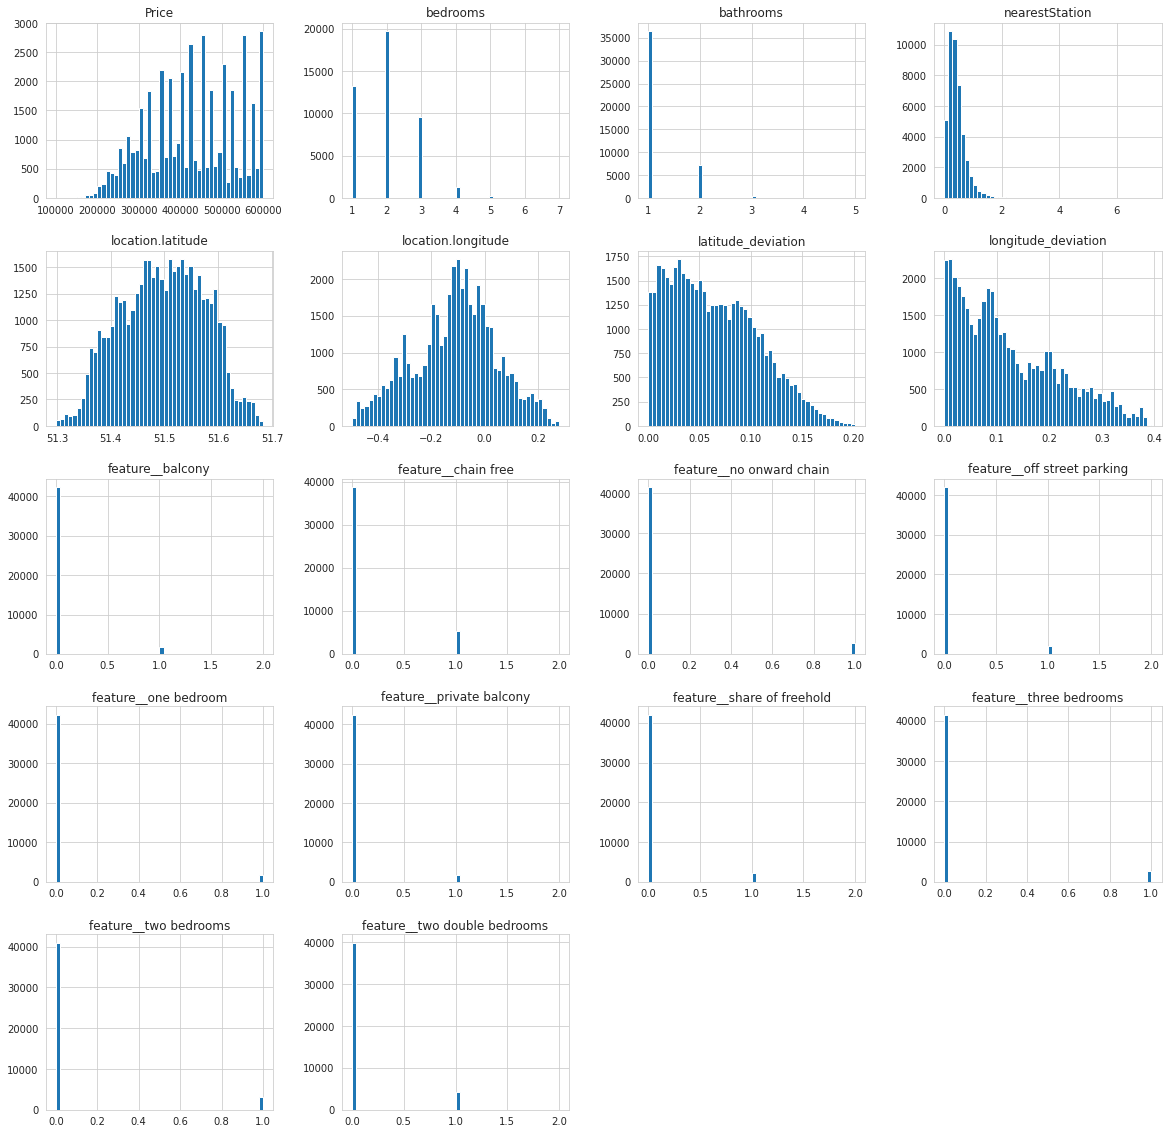

In [13]:
%matplotlib inline
if df.shape[1] < 25:
    df.hist(bins=50, figsize=(20, 20))
    plt.show()

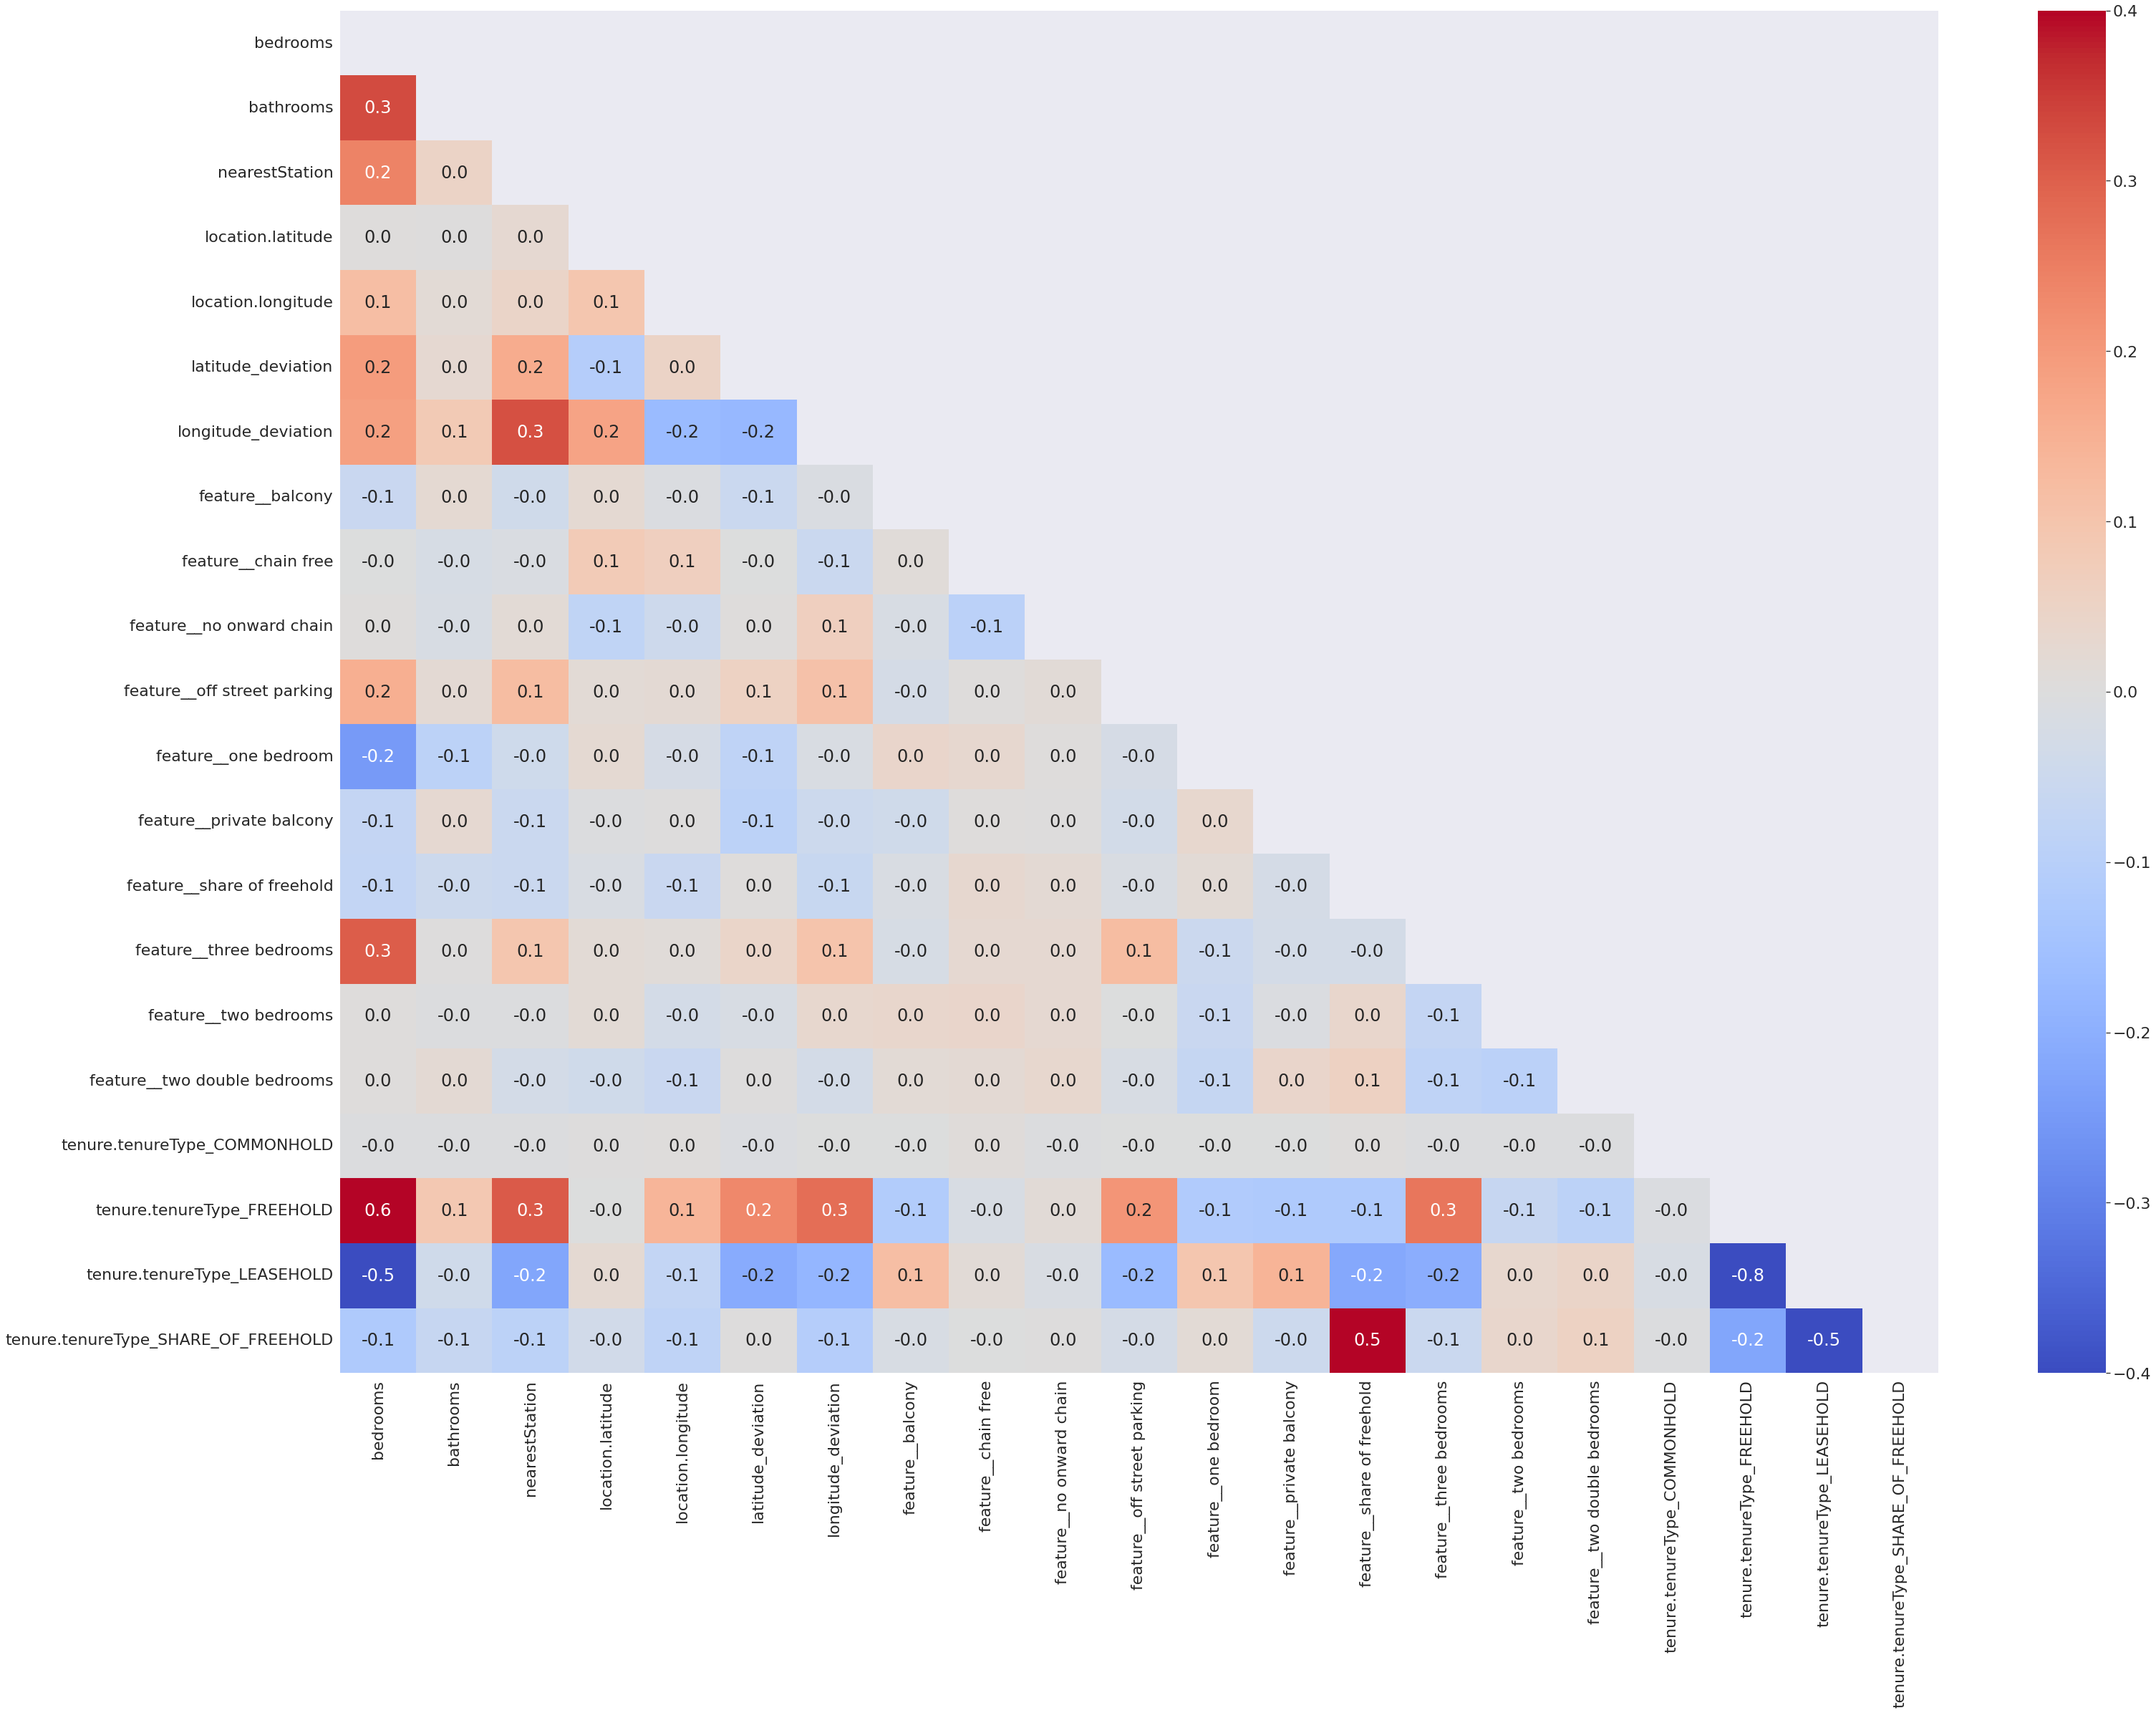

In [14]:
import seaborn as sns
import numpy as np

df_features = df.drop(LABEL, axis=1)
df_features = convert_to_dummied(df_features, categories)
features_corr = df_features.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(features_corr, dtype='bool')
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=2)
plt.figure(figsize=(50, 35))
ax = sns.heatmap(features_corr, annot=True, fmt='.1f', cmap='coolwarm', mask=mask, vmin=-0.4, vmax=0.4)